In [5]:
from dataset import AIArtBenchDataset
from torch.utils.data import DataLoader
import torch
import timm
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision.transforms import Resize, Normalize, Compose, ToTensor, Lambda
from torchvision.models import resnet50
import torch.nn as nn

root = '/home/amk/data/Real_AI_SD_LD_Dataset'

train_data = AIArtBenchDataset(
    root=root,
    for_training=False,
    transforms=None,
    target_transforms=None
)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    Lambda(lambda x: x.float()),  # Convert images to float tensors
    transforms.Resize((299, 299)),
    transforms.Normalize(mean=mean, std=std)
])

reverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])
])

(-0.5, 298.5, 298.5, -0.5)

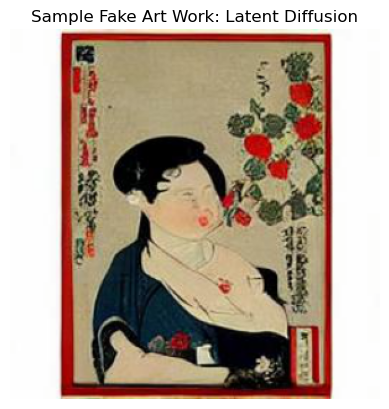

In [14]:
img, label = train_data[2000]
img = transform(img).reshape((1, 3, 299, 299))
img_grad = torch.tensor(img.numpy(), requires_grad=True)

plt.imshow(reverse_transform(img_grad).to(torch.int16).detach().reshape((3, 299, 299)).permute(1, 2, 0))
plt.title('Sample Fake Art Work: Latent Diffusion')
plt.axis('off')

In [15]:
model = timm.create_model('efficientnet_b4', pretrained=False, num_classes=3) #pretrained on imagenet
model.load_state_dict(torch.load('efficient_model.pth'))

for param in model.parameters():
    param.requires_grad = False

class MyResNet(nn.Module):
    def __init__(self, num_classes, is_pretrained=False):
        super(MyResNet, self).__init__()

        # Instantiate a pretrained/randomly-initialized resnet model
        self.resnet_model = resnet50(pretrained=is_pretrained)

        # Modify last layer to map to 3 output classes
        in_features = self.resnet_model.fc.in_features
        self.resnet_model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet_model(x)

model2 = MyResNet(num_classes=3, is_pretrained=False)
model2.load_state_dict(torch.load('resnet_model.pth'))

model3 = models.inception_v3(pretrained=False)
model3.fc = torch.nn.Linear(model3.fc.in_features, 3)
model3.load_state_dict(torch.load('inception_model.pth'))

<All keys matched successfully>

Start losses (EfficientNet)): tensor([[-65.9777, 214.1525, -13.0303]], grad_fn=<AddmmBackward0>)
Start losses (ResNet)): tensor([[-8.8427,  5.8806, -3.7311]], grad_fn=<AddmmBackward0>)
Start losses (Inception)): tensor([[-15.0119,  11.7803,  -8.4142]], grad_fn=<AddmmBackward0>)
epoch 1: loss = 227.18289184570312
epoch 2: loss = 0.379647821187973
epoch 3: loss = 0.22885602712631226
epoch 4: loss = 0.457381933927536
epoch 5: loss = 0.26750943064689636
epoch 6: loss = 0.19808775186538696
epoch 7: loss = 0.2003248631954193
epoch 8: loss = 0.21784456074237823
epoch 9: loss = 0.21093709766864777
epoch 10: loss = 0.23925471305847168
epoch 11: loss = 0.26113635301589966
epoch 12: loss = 0.2513534426689148
epoch 13: loss = 0.25943031907081604
epoch 14: loss = 0.2544898986816406
epoch 15: loss = 0.25351211428642273
epoch 16: loss = 0.25523999333381653
epoch 17: loss = 0.23475004732608795
epoch 18: loss = 0.21658560633659363
epoch 19: loss = 0.21319249272346497
epoch 20: loss = 0.2056554406881332

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


End losses (Inception)): tensor([[-2.6786, -0.9805,  1.6331]], grad_fn=<AddmmBackward0>)


Text(0.5, 1.0, 'Adversarial Attack: EfficientNet')

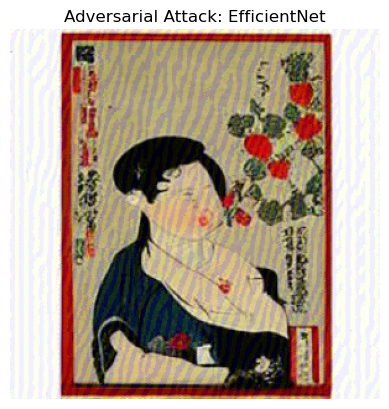

In [16]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([img_grad], lr=10)

target_class_label = 2
target = torch.Tensor([target_class_label]).long()

model.eval()
model2.eval()
model3.eval()

print(f'Start losses (EfficientNet)): {model(img_grad)}')
print(f'Start losses (ResNet)): {model2(img_grad)}')
print(f'Start losses (Inception)): {model3(img_grad)}')


num_epochs = 50
for epoch in range(1, num_epochs+1):
    optimizer.zero_grad()
    output = model(img_grad)
    loss = criterion(output, target)
    loss.backward()

    optimizer.step()

    print(f'epoch {epoch}: loss = {loss}')

    if loss < 1e-10:
        break

print(f'End losses (EfficientNet)): {model(img_grad)}')
print(f'End losses (ResNet)): {model2(img_grad)}')
print(f'End losses (Inception)): {model3(img_grad)}')

plt.imshow(reverse_transform(img_grad).to(torch.int16).detach().reshape((3, 299, 299)).permute(1, 2, 0))
plt.axis('off')
plt.title('Adversarial Attack: EfficientNet')